In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt

import glob

## Read one time series
- ? how to train a model based on different time series?
- choice of threshold depends on the time series pattern

In [2]:
data_path = "./data-sets/KDD-Cup/data/*"
path_list = glob.glob(data_path)

file_path = path_list[0]

In [3]:
params = {
    "point": int(file_path.split("_")[-1].split(".txt")[0]),
    "n_steps": 100,
    "dota": 1.15
}

In [4]:
params

{'point': 30000, 'n_steps': 100, 'dota': 1.15}

In [5]:
data = pd.read_csv(file_path, sep=",", header=None)

In [6]:
train = data.iloc[:params["point"]].reset_index(drop=True)
test  = data.iloc[params["point"]:].reset_index(drop=True)

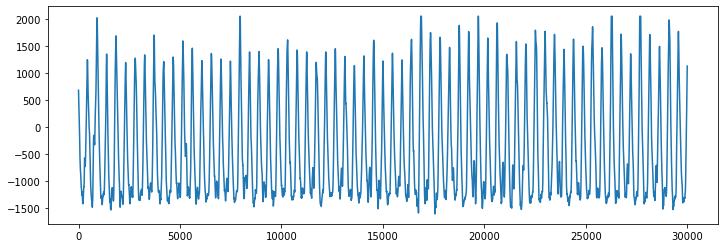

In [7]:
fig, ax = plt.subplots()
train.plot(legend=False, ax=ax, figsize=(12,4))
plt.show()

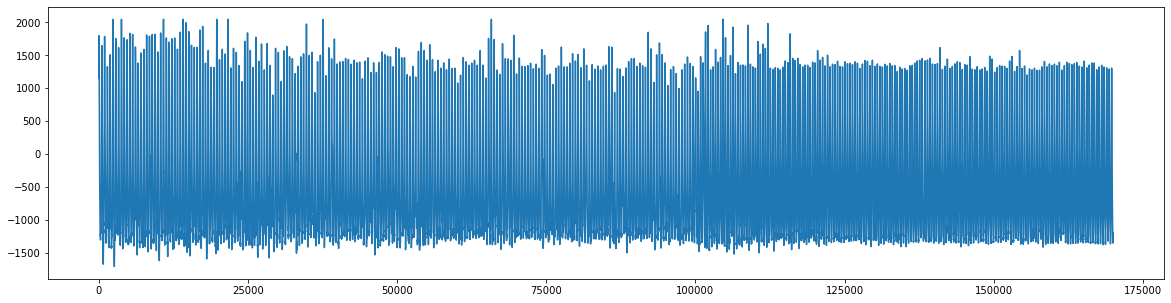

In [8]:
fig, ax = plt.subplots()
test.plot(legend=False, ax=ax, figsize=(20,5))
plt.show()

## Data Proprocessing
- standadization

In [9]:
training_mean = train.mean()
training_std = train.std()
training_value = (train - training_mean) / training_std
print("Number of training samples:", len(training_value))

Number of training samples: 30000


In [10]:
# each train_sample has length of n_steps
# slice the train to get the x_train

def create_sequences(values, steps=params["n_steps"]):
    output = []
    for i in range(len(values) - steps):
        output.append(values[i : (i + steps)])
    return np.stack(output)

x_train = create_sequences(training_value.values)

In [11]:
x_train.shape

(29900, 100, 1)

## Define model architecture

In [13]:
model = tf.keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 50, 16)            80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 8)             520       
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 50, 8)             264       
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 100, 16)           528       
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 100, 1)           

In [15]:
dota_model = model.fit(
    x_train,
    x_train,
    epochs=1000,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/1000
374/374 [==============================] - 3s 6ms/step - loss: 0.5695 - val_loss: 0.0487
Epoch 2/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0654 - val_loss: 0.0320
Epoch 3/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0500 - val_loss: 0.0258
Epoch 4/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0396 - val_loss: 0.0224
Epoch 5/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0322 - val_loss: 0.0217
Epoch 6/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0271 - val_loss: 0.0192
Epoch 7/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0231 - val_loss: 0.0180
Epoch 8/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0198 - val_loss: 0.0182
Epoch 9/1000
374/374 [==============================] - 2s 5ms/step - loss: 0.0172 - val_loss: 0.0184
Epoch 10/1000
374/374 [==============================] - 2s 6ms/step - loss: 0.014

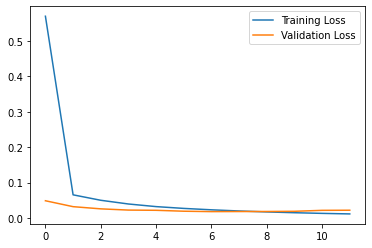

In [16]:
plt.plot(dota_model.history["loss"], label="Training Loss")
plt.plot(dota_model.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

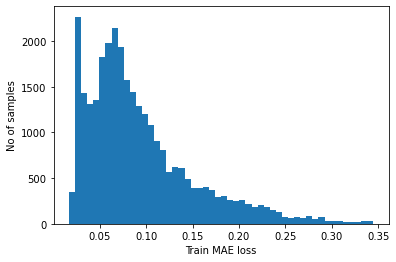

Reconstruction error threshold:  0.34484167290831713


In [17]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

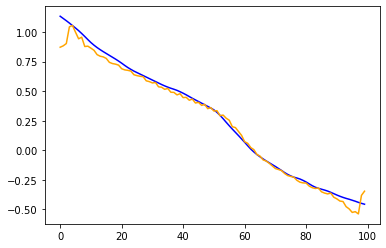

In [19]:
# Checking how the first sequence is learnt
plt.plot(x_train[0], c='blue')
plt.plot(x_train_pred[0], c='orange')
plt.show()

### Predict on test

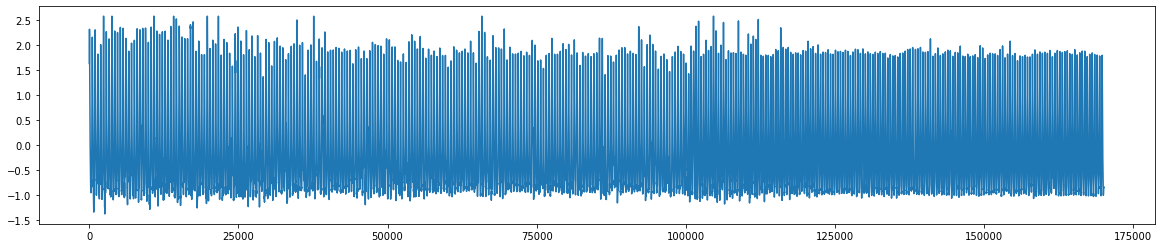

In [24]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

df_test_value = (test - training_mean) / training_std
fig, ax = plt.subplots(figsize=(20,4))
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [22]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (169951, 100, 1)


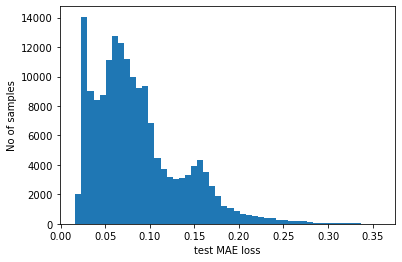

In [23]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [41]:
anomalies = test_mae_loss > threshold * params["dota"]

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  11
Indices of anomaly samples:  (array([104561, 104562, 104563, 104564, 104565, 104566, 104567, 104568,
       104569, 104570, 104571]),)


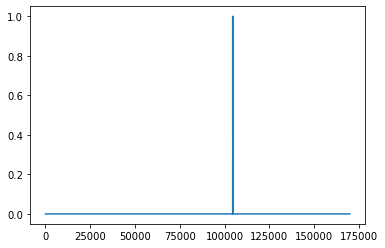

In [35]:
plt.plot(anomalies)
plt.show()